## 0.0 IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
from random import sample
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
from scipy import stats as ss
# from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import os
import requests




### 0.1 HELPER FUNCTIONS


In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat) 
    mape = mean_absolute_percentage_error(y, yhat) 
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    # start and end date for validation
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('KFold Number: {}'.format(k))
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date']<validation_start_date]
        validation = x_training[(x_training['date']>=validation_start_date) & (x_training['date']<=validation_end_date)]

        #training and validation dataset
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation =validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str)  + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str)  + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str)  + ' +/- ' + np.round(np.std(rmse_list),2).astype(str),}, index=[0])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/heitor/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### 0.2 LOADING DATA

In [3]:

df_sales_raw = pd.read_csv('datasets/train.csv',low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv',low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.0 DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

### 1.2 Data Dimensions


In [7]:
print('Numeber of Rows: {}'.format(df1.shape[0]))
print('Numeber of Cols: {}'.format(df1.shape[1]))

Numeber of Rows: 1017209
Numeber of Cols: 18


### 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Fillout NA

In [10]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)# competition_open_since_month  

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year      
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year   
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval    
month_map = {1: 'Jan',2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

### 1.6 Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

### 1.7  Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include = ['float64','int64'])
cat_attributes = df1.select_dtypes(exclude = ['float64','int64','datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [13]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
#Dispercion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.min)).T
d2 = pd.DataFrame(num_attributes.apply(np.max)).T
d3 = pd.DataFrame(num_attributes.apply(np.std)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis)).T

m1 = pd.concat([d1,d2,d4,ct1,ct2,d3,d5,d6]).T.reset_index()
m1.columns = ['attributes','min','max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


/home/heitor/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

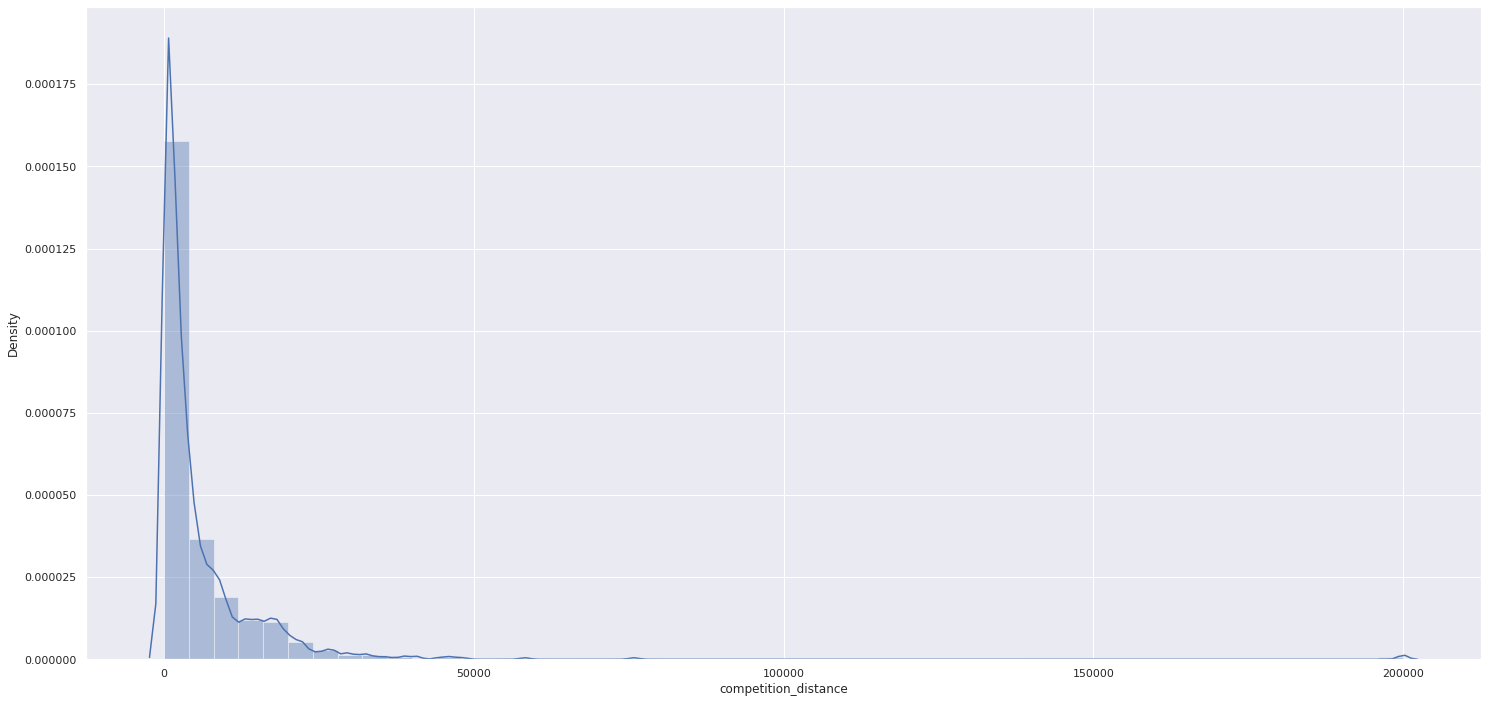

In [14]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

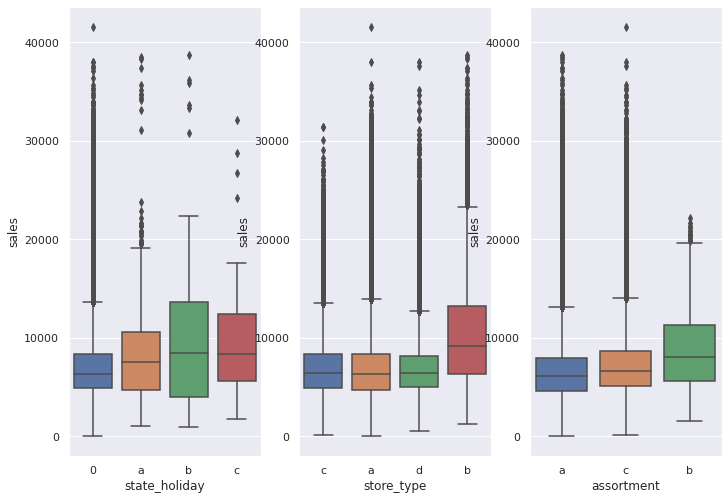

In [16]:
aux1= df1[(df1['state_holiday'] !=0) & (df1['sales']>0)]
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

## 2.0. PASSO 02 - FEATURE ENGINEERING


In [17]:
df2 = df1.copy()

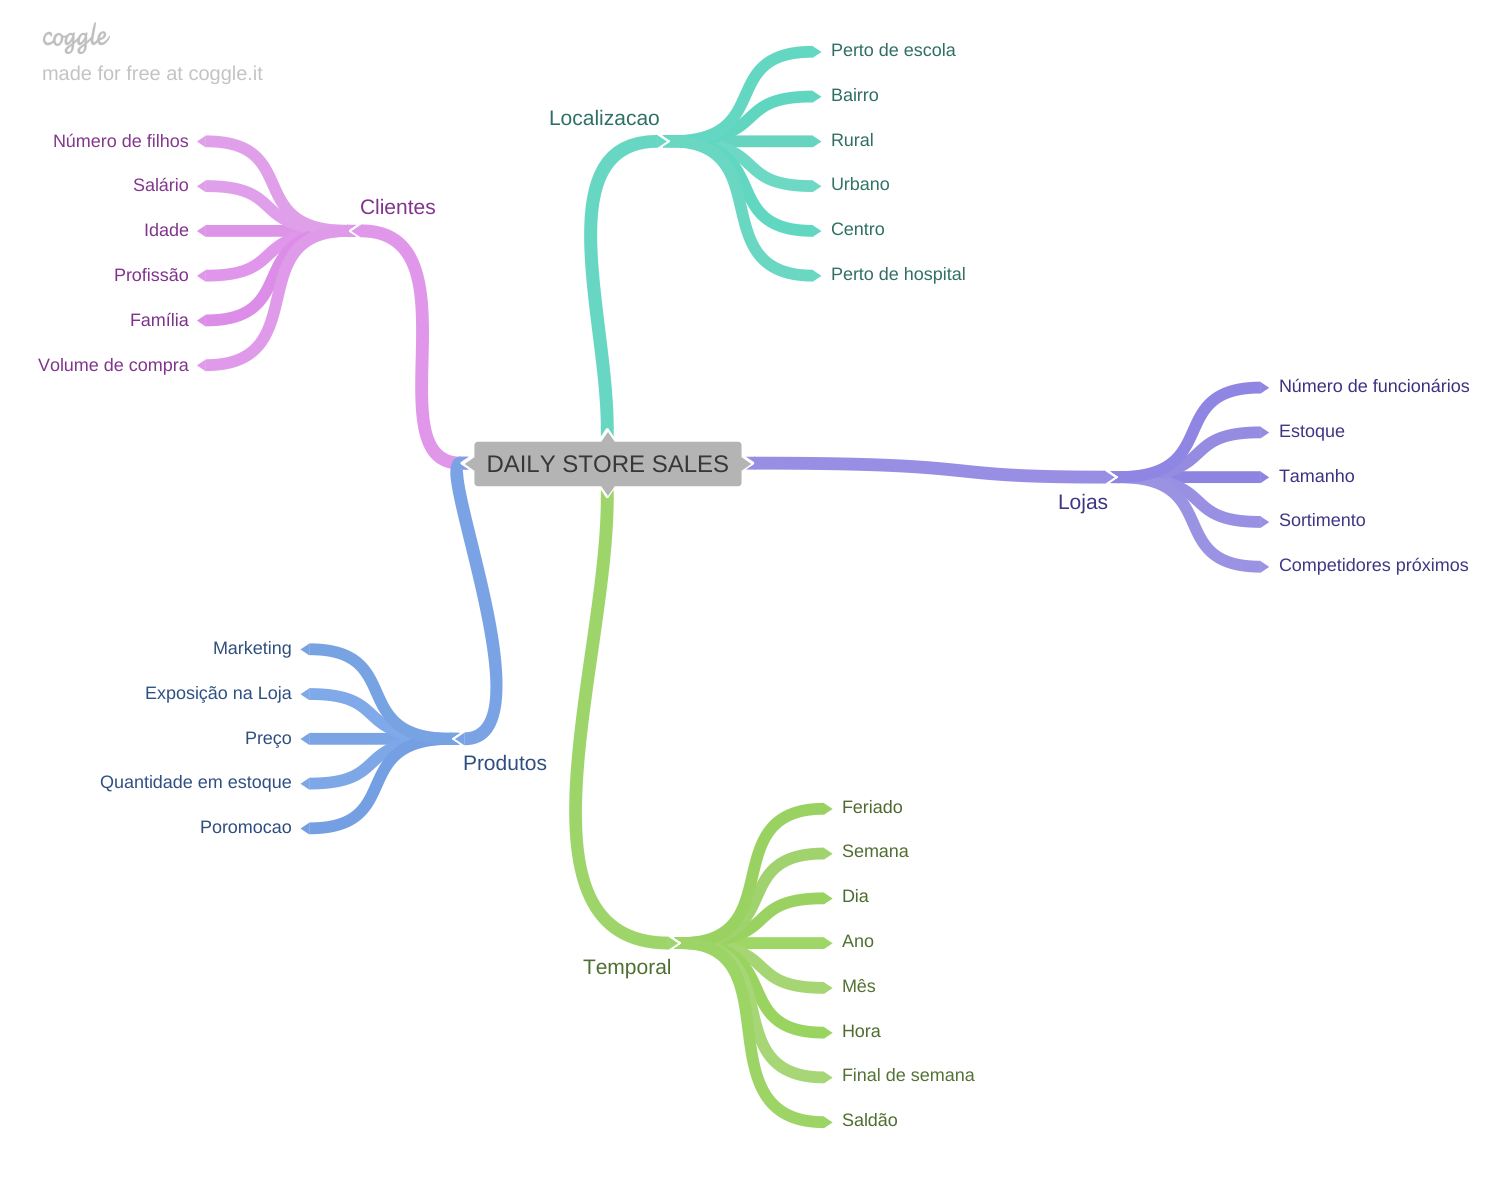

In [18]:
Image('img/mindmap_hyposis.png')

### 2.1. Criação das Hipóteses 

### 2.1.1. Hipóteses Loja


**1. Lojas com número maior de funcionários deveriam vender mais.**

**2. Lojas com maior capacidade de estoque deveriam vender mais.**

**3. Lojas com maior porte deveriam vender mais.**

**4. Lojas com maior sortimentos deveriam vender mais.**

**5. Lojas com competidores mais próximos deveriam vender menos.**

**6. Lojas com competidores à mais tempo deveriam vendem mais.**


### 2.1.2. Hipóteses Produto


**1. Lojas que investem mais em Marketing deveriam vender mais.**

**2. Lojas com maior exposição de produto deveriam vender mais.**

**3. Lojas com produtos com preço menor deveriam vender mais.**

**5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.**

**6. Lojas com promoções ativas por mais tempo deveriam vender mais.**

**7. Lojas com mais dias de promoção deveriam vender mais.**

**8. Lojas com mais promoções consecutivas deveriam vender mais.**


### 2.1.3. Hipóteses Tempo



**1. Lojas abertas durante o feriado de Natal deveriam vender mais.**

**2. Lojas deveriam vender mais ao longo dos anos.**

**3. Lojas deveriam vender mais no segundo semestre do ano.**

**4. Lojas deveriam vender mais depois do dia 10 de cada mês.**

**5. Lojas deveriam vender menos aos finais de semana.**

**6. Lojas deveriam vender menos durante os feriados escolares.**


### 2.2 Hipóteses Finais

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.



### 2.3 Feature Engineering

In [19]:
#year 
df2['year'] = df2['date'].dt.year

#month 
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#weer of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x=='a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day')

## 3.0. PASSO 0 - FILTRAGEM DE VARIÁVEIS

In [20]:
df3=df2.copy()

### 3.1. Filtragem de linhas

In [21]:
df3 = df3[(df3['sales']>0) & df3['open']==1]


### 3.2. Filtragem de colunas

In [22]:

df3 = df3.drop(['open', 'customers', 'promo_interval', 'month_map'], axis=1)

## 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS

In [23]:
df4 = df3.copy()

### 4.1 Análise Univariada


##### 4.1.1 Response Variable


/home/heitor/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


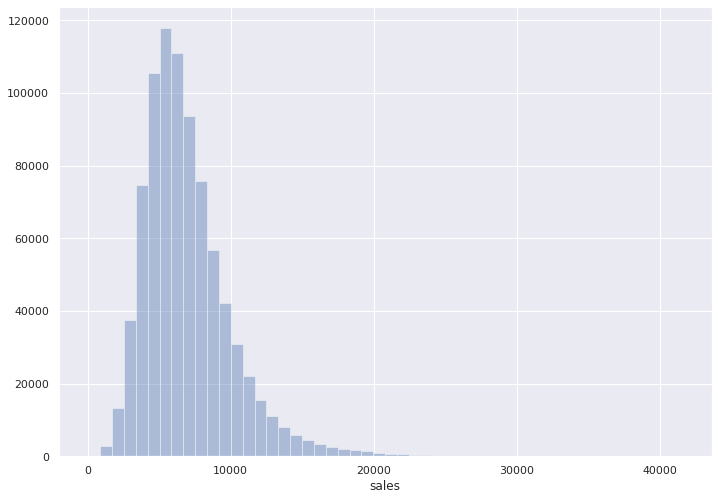

In [24]:
sns.distplot(df4['sales'], kde=False);

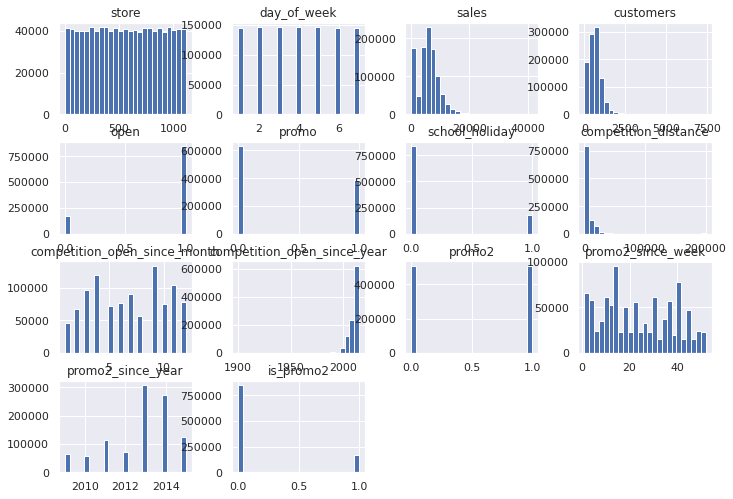

In [25]:
num_attributes.hist(bins=25);

#### 4.1.3. Categorical Variables

/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/heitor/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

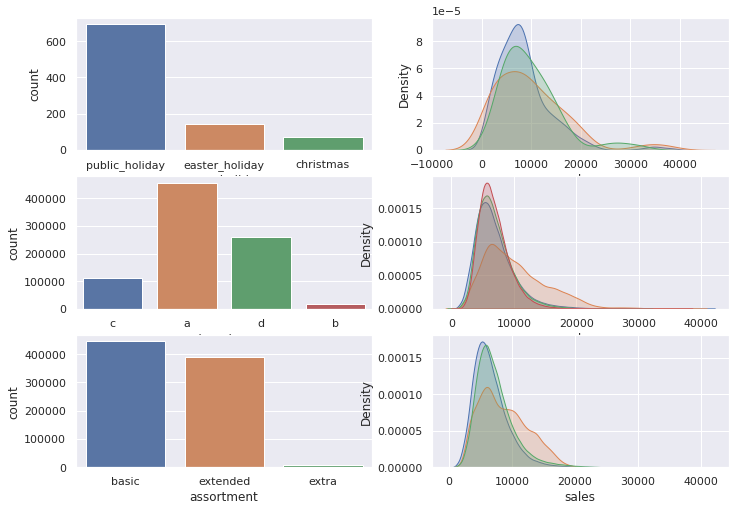

In [26]:

plt.subplot(3,2,1)
a = df4[df4['state_holiday']!='regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
#sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday' ]['sales'], label='public_holiday', shade=True);

sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )


#store type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )




### 4.2. Análise Bivariada

#### **H1.** Lojas com maior sortimentos deveriam vender mais.

**FALSO** Lojas com MAIOR SORTIMENTOS vendem MENOS


<AxesSubplot:xlabel='year_week'>

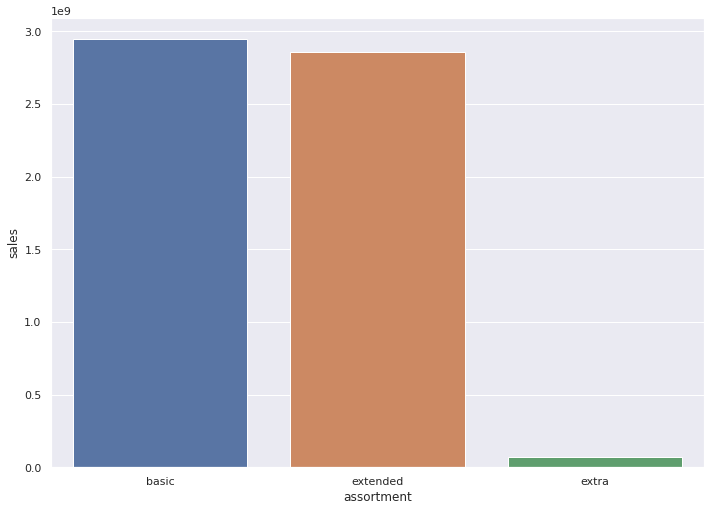

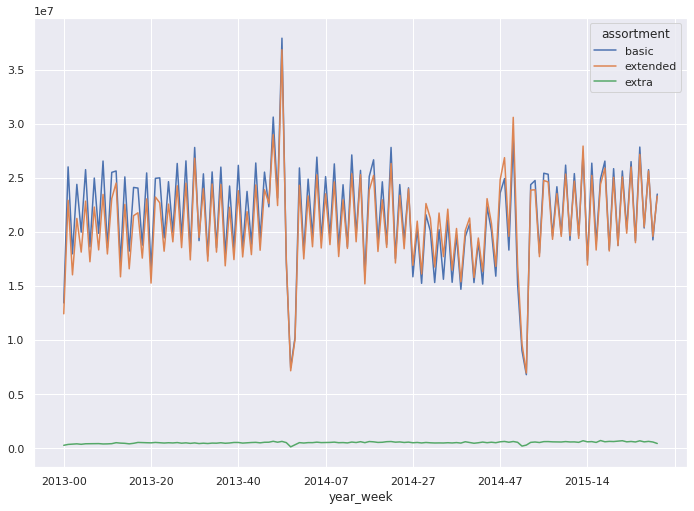

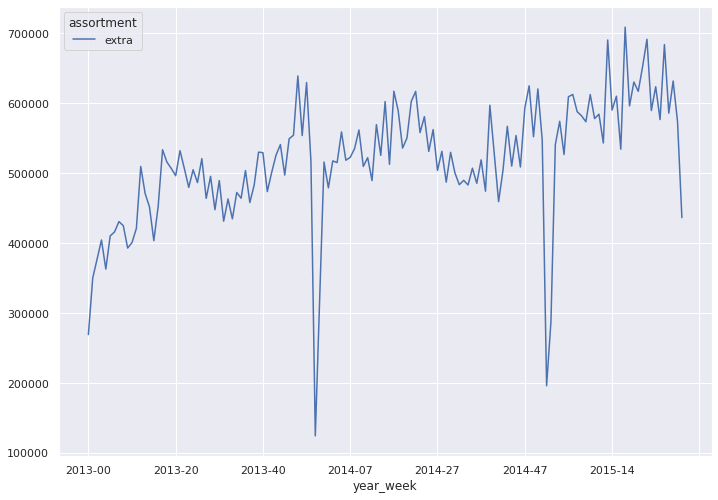

In [27]:
#sales vs assortment
aux1 = df4[['sales', 'assortment']].groupby('assortment').sum().reset_index()
sns.barplot( y='sales', x ='assortment', data=aux1);

#sales vs assortment & year_week
aux2 = df4[['sales', 'assortment', 'year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns='assortment', values='sales').plot()

#sales vs year_week in extra assortment
aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index = 'year_week', columns='assortment', values='sales').plot()

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSO** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

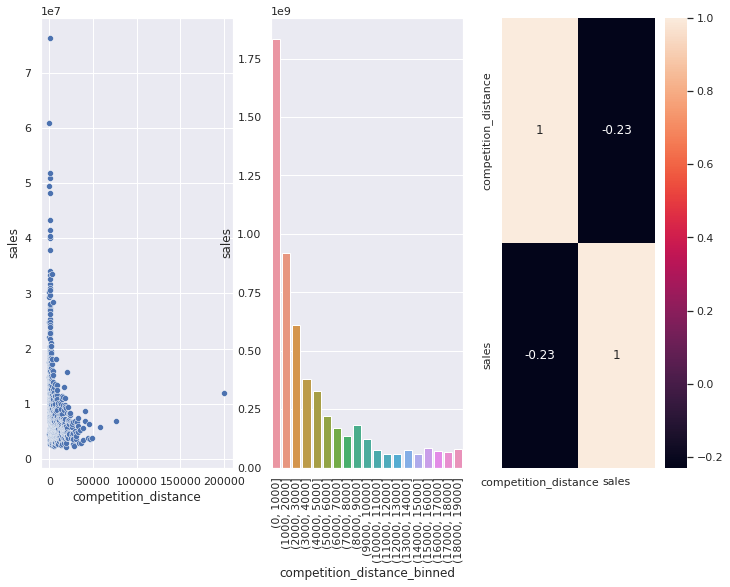

In [28]:
plt.subplot(1,3,1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

#agrupate bins 
plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['sales', 'competition_distance_binned']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );



#### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**FALSO** Lojas com competidores à MAIS TEMPO vendem MENOS


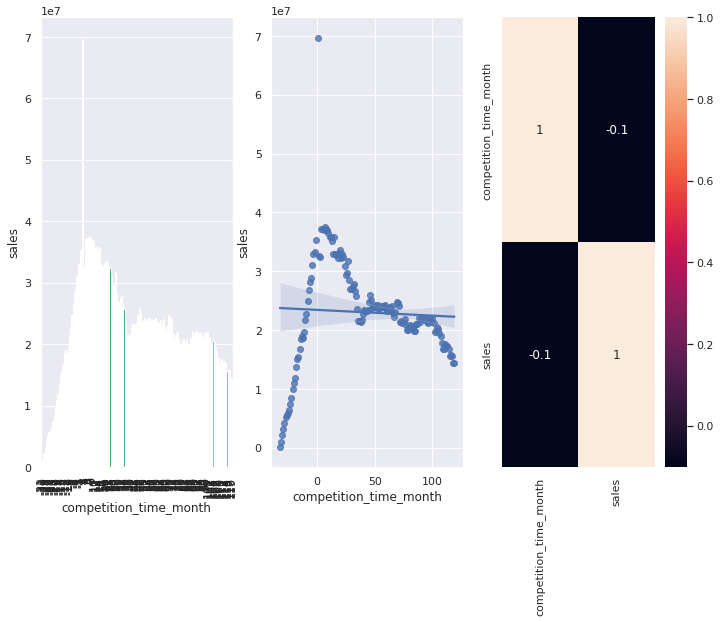

In [29]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['sales', 'competition_time_month']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month']!=0) ]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

#
plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

#heaat map to see the correlation
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );


#### **H4**. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

/tmp/ipykernel_3888/3275863549.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux3['promo_time_week_binned'] = pd.cut(aux3['promo_time_week'], bins=bins)


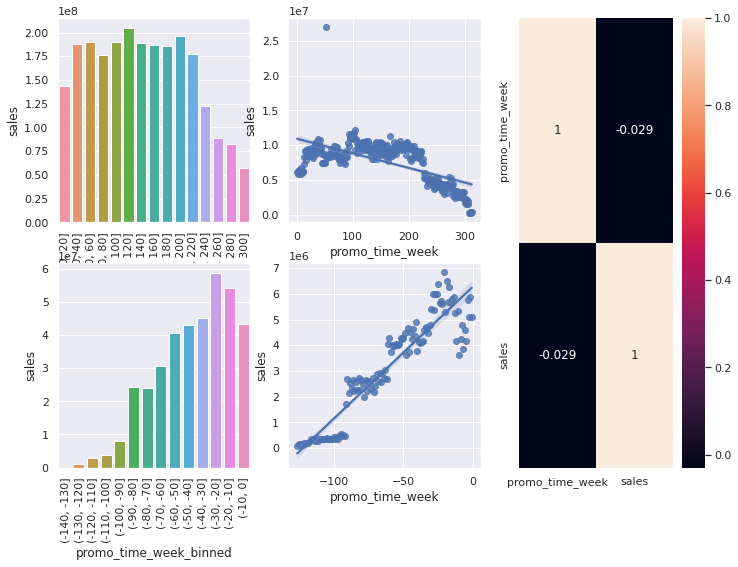

In [30]:

#promo extendida
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot(grid[0,0])
bins = list(np.arange(0,320,20))
aux1['promo_time_week_binned'] = pd.cut(aux1['promo_time_week'], bins=bins)
aux2 = aux1[['sales', 'promo_time_week_binned']].groupby('promo_time_week_binned').sum().reset_index()
sns.barplot(x='promo_time_week_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

# aux2 = aux1[aux1['promo_time_week']>0]
# plt.subplot(grid[0,0])
# sns.barplot(x='promo_time_week',y='sales', data=aux2);
# plt.xticks(rotation=90);

plt.subplot(grid[0,1])
aux2 = aux1[aux1['promo_time_week']>0]
sns.regplot(x='promo_time_week',y='sales', data=aux2);

#promo regular
plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0]
bins = list(np.arange(-140,1,10))
aux3['promo_time_week_binned'] = pd.cut(aux3['promo_time_week'], bins=bins)
aux4 = aux3[['sales', 'promo_time_week_binned']].groupby('promo_time_week_binned').sum().reset_index()
sns.barplot(x='promo_time_week_binned', y='sales', data=aux4);
plt.xticks(rotation=90);
# plt.subplot(grid[1,0])

# sns.barplot(x='promo_time_week',y='sales', data=aux3);
# plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales', data=aux3);

#heatmap of all items
plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


#### **H5.** Lojas com mais dias de promoção deveriam vender mais.

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSO** Lojas com MAIS PROMOÇÕES CONSECUTIVAS vendem MENOS

In [31]:
df4[['sales', 'promo', 'promo2']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


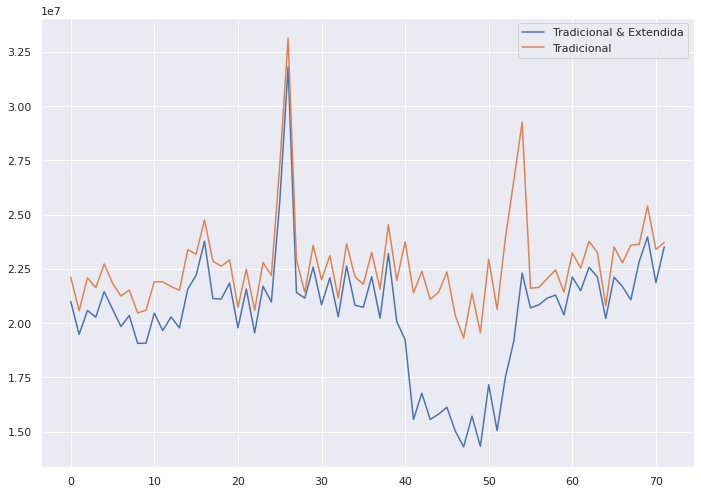

In [32]:

#Tradicional 
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax= aux1.plot()

#Tradicional & Extendida
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

#legendas
ax.legend( labels=['Tradicional & Extendida', 'Tradicional']);


#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

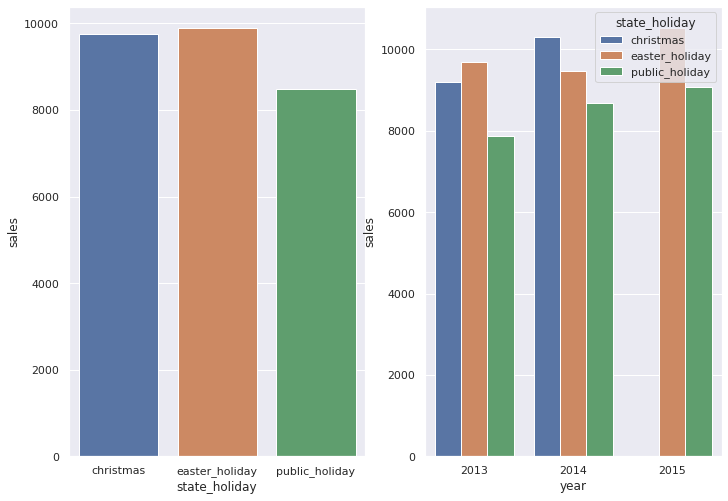

In [33]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['state_holiday','year']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday',data=aux2);


#### **H8.** Lojas deveriam vender mais ao longo dos anos.

**FALSO** As lojas vendem MENOS ao longo dos anos



<AxesSubplot:>

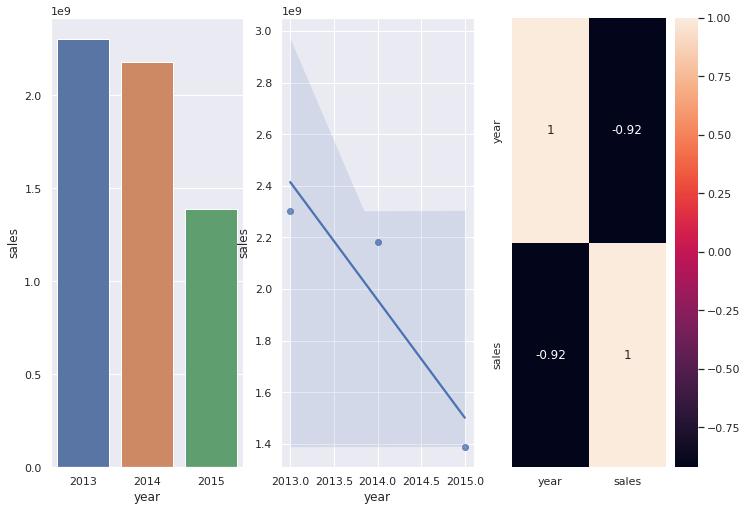

In [34]:
plt.subplot(1,3,1)
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux);

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)



#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

**FALSO** Lojas vendem MENOS no SEGUNDO SEMESTRE do ano

<AxesSubplot:>

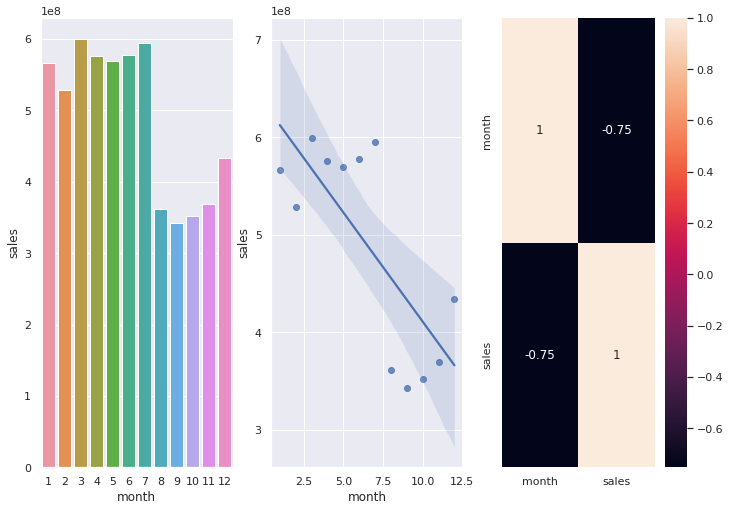

In [35]:
#barplot
plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)



#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADE** Lojas vedem mais depois do dia 10 de cada mês

<AxesSubplot:xlabel='before_after', ylabel='sales'>

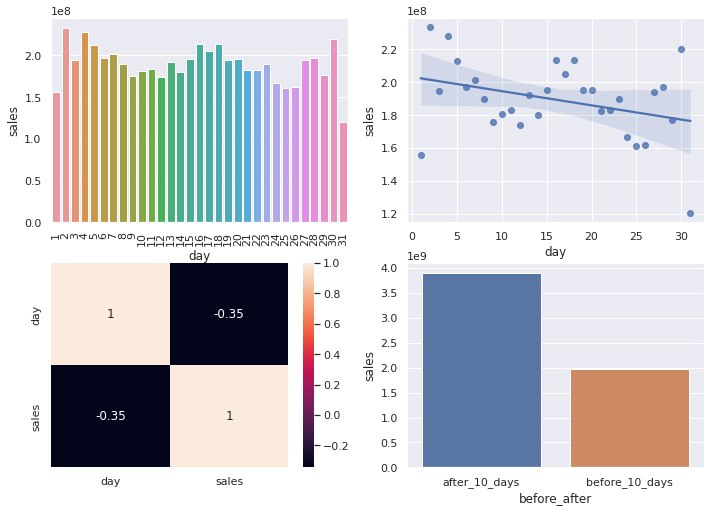

In [36]:
plt.subplot(2,2,1)
aux1 = df4[['sales', 'day']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'after_10_days' if x>10 else 'before_10_days')
aux2 = aux1[['sales', 'before_after']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2)


#### **H11.** Lojas deveriam vender menos aos finais de semana.

**VERDADE** Lojas vendem menos aos fins de semana

<AxesSubplot:>

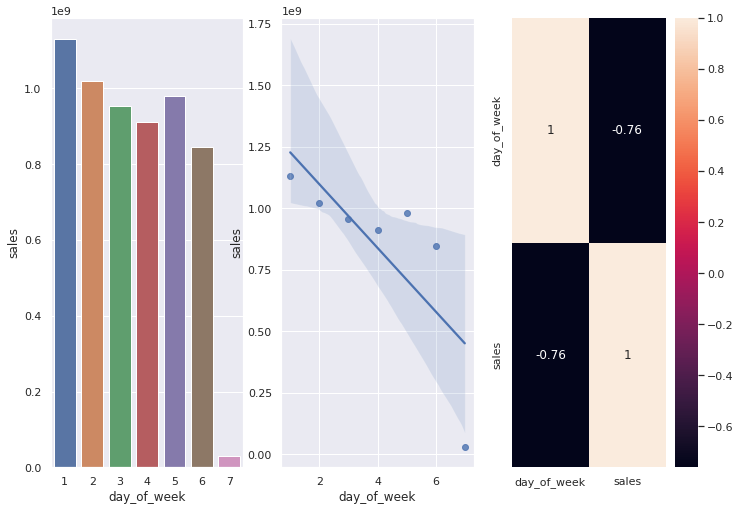

In [37]:
aux1 = df4[['sales', 'day_of_week']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)




#### **H12.** Lojas deveriam vender menos durante os feriados escolares.

**FALSO** Em média, as lojas vendem mais durante os feriados, mas a diferença é muito pequena

<AxesSubplot:xlabel='month', ylabel='sales'>

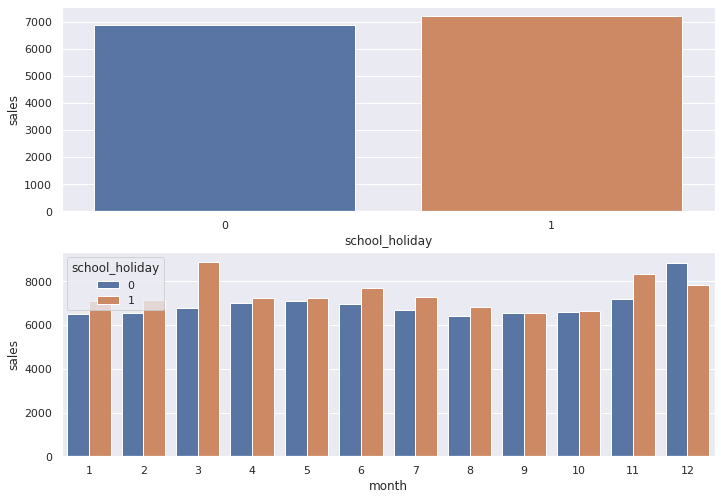

In [38]:
aux1 = df4[['sales', 'school_holiday']].groupby('school_holiday').mean().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['sales', 'school_holiday', 'month']].groupby(['school_holiday', 'month']).mean().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2)



### 4.3. Análise Multivariada

#### 4.3.1. Numerical Attributes

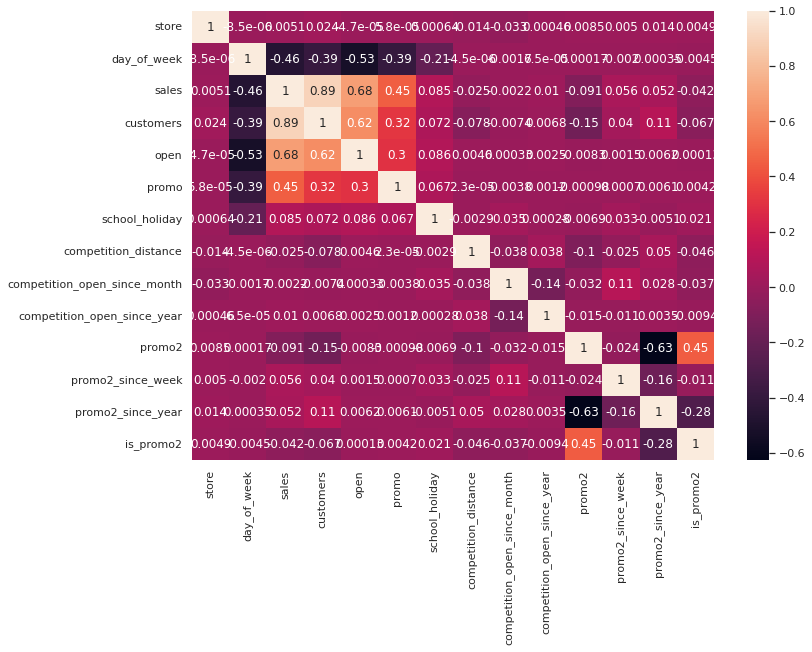

In [39]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

#### 4.3.2. Categorical Attributes

In [30]:
#only categorical data
a = df4.select_dtypes('object')

# Calculate cramer V


In [41]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))
    

In [42]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9],
             })

d = d.set_index(d.columns)


<AxesSubplot:>

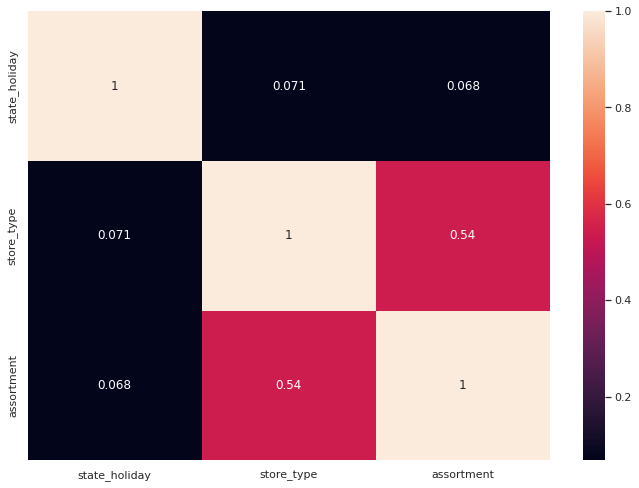

In [43]:
sns.heatmap(d, annot=True)

## 5.0. PASSO 05 - DATA PREPARATION

In [24]:
df5 = df4.copy()

### 5.1.  Normalização

### 5.2. Rescaling

In [25]:
rs = RobustScaler()
mms = MinMaxScaler()
path = os.getcwd()
#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open( path + '/parameters/competition_distance_scaler.pkl', 'wb'))

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open( path + '/parameters/competition_time_month_scaler.pkl', 'wb'))


#promo time week
df5['promo_time_week'] = rs.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open( path + '/parameters/promo_time_week_scaler.pkl', 'wb'))


#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open( path + '/parameters/year_scaler.pkl', 'wb'))


### 5.3. Transformation

#### 5.3.1 Encoding 

In [26]:
#state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])



In [27]:
#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5[['store_type']])
pickle.dump(le, open( path + '/parameters/store_type_scaler.pkl', 'wb'))

#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

/home/heitor/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### 5.3.2. Response Variable Transformation


In [28]:
#logaritimic transformation
df5['sales'] = np.log1p(df5['sales'])

#### 5.3.3. Nature Transformation

In [29]:
#day of week 
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin ( x* ( 2*np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos ( x* ( 2*np.pi/7 ) ) )
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin ( x* ( 2*np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos ( x* ( 2*np.pi/12 ) ) )
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin ( x* ( 2*np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos ( x* ( 2*np.pi/30 ) ) )
#week of year

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin ( x* ( 2*np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos ( x* ( 2*np.pi/52 ) ) )

In [30]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.000000,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,2.559633,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,2.073394,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.000000,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.000000,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.0. PASSO 06 - FEATURE SELECTION

In [31]:
df6 = df5.copy()

### 6.1. Split dataframe into training and test dataset

In [32]:
#dropping columns that will not be used
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [33]:
#setting the time limit to make train and test
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)


Timestamp('2015-06-19 00:00:00')

In [34]:
#train dataset
X_train = df6[df6['date'] < '2015-06-19'] #variáveis de treino
Y_train = X_train['sales'] #variavel resposta do treino

#test dataset
X_test = df6[df6['date'] >= '2015-06-19'] #variáveis de teste
Y_test = X_test['sales'] #variavel resposta do treino


#train interval
print('Training Min Dates:{}'.format(X_train['date'].min()))
print('Training Max Dates:{}'.format(X_train['date'].max()))

#test interval
print('Test Min Dates:{}'.format(X_test['date'].min()))
print('Test Max Dates:{}'.format(X_test['date'].max()))

Training Min Dates:2013-01-01 00:00:00
Training Max Dates:2015-06-18 00:00:00
Test Min Dates:2015-06-19 00:00:00
Test Max Dates:2015-07-31 00:00:00


### 6.2. Boruta as feature selector

In [35]:
# #training and test dataset for Boruta
# #removing date and sales of train variables
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# Y_train_n = Y_train.values.ravel()

# #define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)
# #define boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=41).fit(X_train_n, Y_train_n)

#### 6.2.1 Best Features from Boruta

In [36]:
# cols_selected = boruta.support_.tolist()

# #best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# #not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns , cols_selected_boruta))

### 6.3. Manual Feature Selection

In [37]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin']

In [38]:
#columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## 7.0. PASSO 07 - MACHINE LEARNING MODELING


In [39]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]


### 7.1. Average Model

In [47]:
#copying test variables
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

#calculation sales prediction by mean by store
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


### 7.2. Linear Regression Model

In [61]:
# #model
# lr = LinearRegression().fit(x_train, Y_train)

# #prediction
# yhat_lr = lr.predict(x_test)

# #performance
# lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
# lr_result

#### 7.2.2 Linear Regression - Cross Validation

In [62]:
lr = LinearRegression()
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)


In [63]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


### 7.3. Linear Regression Regularized Model - Lasso

In [64]:
# #model
# lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

# #prediction
# yhat_lrr = lrr.predict(x_test)

# #performance
# lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
# lrr_result

#### 7.3.1 Lasso - Cross Validation

In [65]:
lrr = Lasso()
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2388.68 +/- 398.48,0.34 +/- 0.01,3369.37 +/- 567.55


### 7.4. Random Forest Regressor

In [66]:
# #model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=41).fit(x_train, Y_train)
# #prediction
# yhat_rf = rf.predict(x_test)

# #performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
# rf_result

#### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
rf = RandomForestRegressor()
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


### 7.5. XGBoost Regressor

In [ ]:
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                              n_estimators=100 ).fit( x_train, Y_train )

# #prediction
# yhat_xgb = model_xgb.predict(x_test)

# #performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
# xgb_result

#### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
model_xgb = xgb.XGBRegressor()
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

### 7.6. Compare Model's Performance

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

In [ ]:
model = LinearRegression()
a = cross_validation(x_training, 5, 'Linear Regression', model)

#### 7.6.1. Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

## 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

### 8.1. Random Search

In [ ]:
# param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
# 'eta': [0.01, 0.03],
# 'max_depth': [3, 5, 9],
# 'subsample': [0.1, 0.5, 0.7],
# 'colsample_bytree': [0.3, 0.7, 0.9],
# 'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 5


# import random
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#     # choose values for parameters randomly
#     hp = { k: random.sample(  v, 1 )[0] for k, v in param.items() }
#     print( hp )

#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#     n_estimators=hp['n_estimators'],
#     eta=hp['eta'],
#     max_depth=hp['max_depth'],
#     subsample=hp['subsample'],
#     colsample_bytree=hp['colsample_bytree'],
#     min_child_weight=hp['min_child_weight'] )
    
#     #Performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#     final_result = pd.concat([final_result, result])

# final_result

### 8.2. Final Model

In [59]:
param_tuned = {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}

# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
n_estimators=param_tuned['n_estimators'],
eta=param_tuned['eta'],
max_depth=param_tuned['max_depth'],
subsample=param_tuned['subsample'],
colsample_bytree=param_tuned['colsample_bytree'],
min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, Y_train )

                                   
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned

KeyboardInterrupt: 

In [41]:
# param_tuned = {
# 'n_estimators': 3000,
# 'eta': 0.03,
# 'max_depth': 5,
# 'subsample': 0.7,
# 'colsample_bytree': 0.7,
# 'min_child_weight': 3
# }

# # model
# model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
# n_estimators=param_tuned['n_estimators'],
# eta=param_tuned['eta'],
# max_depth=param_tuned['max_depth'],
# subsample=param_tuned['subsample'],
# colsample_bytree=param_tuned['colsample_bytree'],
# min_child_weight=param_tuned['min_child_weight']).fit( x_train, Y_train )

# #prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# # performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1(yhat_xgb_tuned ) )
# xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,662.257619,0.097974,951.67959


## 9.0. PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [42]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

/tmp/ipykernel_4538/403577207.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
/tmp/ipykernel_4538/403577207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


### 9.1. Business Performance

In [ ]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})

df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

In [ ]:
#Merge 
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions','worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df92

In [ ]:
sns.scatterplot(x='store', y='MAPE', data=df92)

### 9.2. Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

### 9.3. ML Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales', data=df9, label='SALES')
sns.lineplot(x='date',y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate', data=df9)
plt.axhline(1 , linestyle = '--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error'])

## 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

### 10.1. Rossmann Class

In [ ]:
#Save Trained Model
path = os.getcwd()
pickle.dump( model_xgb_tuned, open( path + '\\webapp\\model\\model_rossmann.pkl', 'wb') )

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = path 
        self.competition_distance_scaler = pickle.load( open( self.home_path + '\\parameters\\competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open( self.home_path + '\\parameters\\competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler =  pickle.load( open( self.home_path + '\\parameters\\promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler =  pickle.load( open( self.home_path + '\\parameters\\year_scaler.pkl', 'rb'))
        self.store_type_scaler = pickle.load( open( self.home_path + '\\parameters\\store_type_scaler.pkl', 'rb'))
    def data_cleaning(self, df1):
        
        
        ### 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new

        ### 1.5. Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)# competition_open_since_month  

        # competition_open_since_month

        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year      
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week  
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year   
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval    
        month_map = {1: 'Jan',2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

        ### 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        return df1


    def feature_engineering(self,df2):
        

        #year 
        df2['year'] = df2['date'].dt.year

        #month 
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #weer of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x=='a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day')

        ### 3.1. Filtragem de linhas
        df2 = df2[(df2['sales']>0)]


        ### 3.2. Filtragem de colunas
        df2 = df2.drop(['open', 'promo_interval', 'month_map'], axis=1)
        return df2



    def data_preparation(self, df5):

        ### 5.2. Rescaling
        #competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)


        #promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        #### 5.3.1 Encoding 

        #state holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5[['store_type']])

        #assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        #### 5.3.2. Response Variable Transformation
        #### 5.3.3. Nature Transformation

        #day of week 
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin ( x* ( 2*np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos ( x* ( 2*np.pi/7 ) ) )
        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin ( x* ( 2*np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos ( x* ( 2*np.pi/12 ) ) )
        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin ( x* ( 2*np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos ( x* ( 2*np.pi/30 ) ) )
        #week of year

        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin ( x* ( 2*np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos ( x* ( 2*np.pi/52 ) ) )
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2',
                                'promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos','month_sin',
                                'month_cos','day_sin','day_cos','week_of_year_cos','week_of_year_sin']
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = modelpredict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expn1(pred)
        
        return original_data.to_json(orient='records', data_format='iso')

### 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann
import os

path = os.getcwd()

#loading model
model = pickle.load(open( path + 'model//model_rossman.pkl', 'rb'))

#initialize API
app = Flask(__name__)

@app.route('/rossman/predict',method=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json, dict): #unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
       #Instanciate Rossman class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ =='__main__':
    app.run('0.0.0.0')

### 10.3. API Tester

In [ ]:

df10 = pd.read_csv('./datasets/test.csv')

In [ ]:

#merge test dataset + store
df_test = pd.merge(df10,df_store_raw, how='left', on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'].isin([24,26,9, 1, 3,4, 5,])]
# df_test = df_test[df_test['Store'][24]
#remove closed days
df_test =  df_test[df_test['Open'] ==1]
df_test =  df_test[-df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [ ]:
import json
#convert dataframe to json

data = json.dumps(df_test.to_dict(orient='records'))


In [ ]:
 # API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
# url = 'https://dashboard.heroku.com/apps/rossmann-sales-ds/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'],d2.loc[i, 'prediction'] ) )
